In [74]:
import gwsurrogate
import numpy as np
import matplotlib.pyplot as plt
import bilby
from gwpy.timeseries import TimeSeries

In [75]:
sur=gwsurrogate.LoadSurrogate('NRSur7dq4')

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/Users/zohaggard/anaconda2/envs/igw

Loaded NRSur7dq4 model


In [76]:
def sigmoid(x, x0, L, k):
    
    """ generate a sigmoid to be mult. to damped sinusoid.
        x is time, x0 is the midpoint of the sigmoid, L is the amplitude, and k is the growth 
    """
    
    sig = []
    
    for item in x:
        value=L/(1+np.exp(-k*(item-x0)))
        sig.append(value)
    return sig

In [77]:
def create_bru_values(m_odd, em, M, a, n_ref):
    
    """ 
    m_odd is odd integer, g_s is string coupling (GR == 1), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns amplitude (quantum), omega_real, tau, and tp
    
    """
    
    g_s = 1/n_ref
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    tp = 1/omega_real 
    
    print("Quantum freq is {}".format(omega_real/(2*np.pi)))
    print("Quantum tau is {}".format(tau))
    
    return {'omega_real_Q': omega_real, 'omega_img_Q': omega_im,
            'tau_Q': tau, 'tp_Q': tp, 'freq_Q': (omega_real/(2*np.pi))}

In [78]:
def damped_sine(time, amplitude, tau, tp, omega_real, phase):
    
    """
    returns damped complex sine as h (type=array) 
    assumes that tau is negative number
    starts a time tp: anytime before is 0

    """
    
    
    h = np.zeros(len(time), dtype=np.complex128)
    tidx = time >= tp
    
    damp_arg = (time[tidx])/tau
    sin_arg = (omega_real * (time[tidx])) - phase
    h[tidx] = amplitude*np.exp(damp_arg) * np.exp((1j*sin_arg)) 
    
    return h

In [79]:
def NRsur_Quantummodes(time, q, chiA, chiB, M, dist_mpc, inclination, a, n_ref, amplitude, phase, **kwargs):
    
    """ 
    model that has NR SUR (for given parameters) and associated quantum mode 
    chiA and chiB take [x,y,x] as input
    assumes dt = 1/4096
    highest l index is ellMax, assumed to be 4
    f_ref=30, and f_low=0
    
    note: NRSUR peak of waveform packet is at t=0
    
          spin=0 for now (need to change em otherwise)
    
    """
    
    #generate NRSUR

    f_ref = 30     # Reference frequecny in Hz. The spins are assumed to specified at this frequency
    f_low = 0      # initial frequency, f_low=0 returns the full surrogate  
      # step size in seconds
    ellMax = 4     # Highest l index for modes to use

    t, h, dyn = sur(q, chiA, chiB, times=time, f_low=f_low, f_ref=f_ref, 
                    ellMax=ellMax, M=M, dist_mpc=dist_mpc, units='mks',
                    inclination=inclination)
    print(t)
    bru_values = create_bru_values(m_odd=1, em=0, M=M, a=a, n_ref=n_ref)
    
    bru_sin = damped_sine(time=time, amplitude=amplitude, 
                       tau=bru_values['tau_Q'], tp=bru_values['tp_Q'], 
                       omega_real=bru_values['omega_real_Q'], phase=phase)
    
    sig = sigmoid(x=time, x0=bru_values['tp_Q']*2, L=amplitude, k=4096)
    
    h_total = bru_sin*sig/amplitude
    
    return {'plus':h_total.real, 'cross':h_total.imag}
    

In [80]:
injection_waveform.time_array

array([-0.84718446, -0.84694032, -0.84669618, ...,  0.01902648,
        0.01927062,  0.01951476])

In [68]:
t

array([-0.84718446, -0.84694032, -0.84669618, ...,  0.01902648,
        0.01927062,  0.01951476])

In [71]:
injection_parameters = dict(q=1, chiA=[0,0,0], chiB=[0,0,0], M=40, 
                            dist_mpc=235, inclination=0,
                            a=0, n_ref=5,amplitude=1e-21, phase=0,
                            ra=0, dec=, psi=0)

In [72]:
injection_waveform = bilby.gw.waveform_generator.WaveformGenerator(
    time_domain_source_model=NRsur_Quantummodes,
    duration=len(t)/4096, sampling_frequency=4096, 
    start_time=t[0])

In [73]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    duration=len(t)/4096, sampling_frequency=4096,
    start_time=)

ifos.inject_signal(waveform_generator=injection_waveform,
                   parameters=injection_parameters)

SyntaxError: invalid syntax (<ipython-input-73-b4219c2e754e>, line 4)

In [215]:
ifos.set_strain_data_from_power_spectral_densities()

TypeError: set_strain_data_from_power_spectral_densities() missing 2 required positional arguments: 'sampling_frequency' and 'duration'

In [153]:
time=np.arange(-1,1,1/4096)
print(time)

[-1.         -0.99975586 -0.99951172 ...  0.99926758  0.99951172
  0.99975586]


In [56]:
q = 1
chiA = [0,0,0]
chiB = [0,0,0]      # Reference frequecny in Hz. The spins are assumed to specified at this frequency         # initial frequency, f_low=0 returns the full surrogate
M = 40   # Total masss in solar masses
dist_mpc = 235     # distance in megaparsecs       # step size in seconds
ellMax = 4     # Highest l index for modes to use
inclination = 0
dt=1/4096

# dyn stands for dynamics, do dyn.keys() to see contents
times, h, dyn = sur(q, chiA, chiB, times=[0,0.001], f_low=0, ellMax=ellMax, M=M, dist_mpc=dist_mpc,
               inclination=inclination, units='mks')

TypeError: unsupported operand type(s) for /: 'list' and 'float'

[4.01, 0.801]

In [39]:
times=np.arange(-0.7,0.001,1/4096)

In [42]:
_, h, dyn = sur(q, chiA, chiB, times=times, freqs=None, f_low=f_low, f_ref=f_ref, ellMax=ellMax, M=M, dist_mpc=dist_mpc,
               inclination=inclination, units='mks')

Exception: times were given as input but returned domain somehow does not match.

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

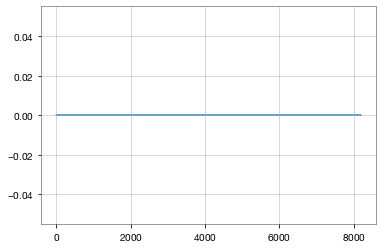

In [164]:
plt.plot(t_new)